In [1]:
# Import packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

In [2]:
# Read in air quality data
aqs_file = "C:/Users/rache/Documents/University of Southern California/2023-2024 Year 4/GEOL 599 Environmental data science/data/HW3_LA_AQS_2023.csv" #note on path
aqs = pd.read_csv(aqs_file)
aqs= aqs.loc[:,['Parameter Name','Duration Description','Date (Local)','Arithmetic Mean','Units of Measure']]
aqs = aqs.rename(columns={'Parameter Name':'Parameter','Date (Local)': 'Date', 'Arithmetic Mean': 'Value', 'Duration Description': 'Duration','Units of Measure':'Units'})

In [3]:
# Check out the aqs data
aqs.head()

,Parameter,Duration,Date,Value,Units
0,Ambient Min Temperature,24 HOUR,2023-01-01,10.100000,Degrees Centigrade
1,Nitrogen dioxide (NO2),1 HOUR,2023-01-01,4.816667,Parts per billion
2,Relative Humidity,1 HOUR,2023-01-01,69.916667,Percent relative humidity
3,Outdoor Temperature,1 HOUR,2023-01-01,55.291667,Degrees Fahrenheit
4,Oxides of nitrogen (NOx),1 HOUR,2023-01-01,5.366667,Parts per billion


In [4]:
# Select ozone, NO2 and PM 2.5 from the aqs data
O3 = aqs[(aqs['Parameter']=='Ozone') & (aqs['Duration']=='1 HOUR')]
O3.loc[:,'Value'] = O3.loc[:,'Value']*1000 #Convert to ppb
O3.loc[:,'Units'] = "Parts per billion"
NO2 = aqs[(aqs['Parameter']=='Nitrogen dioxide (NO2)') & (aqs['Duration']=='1 HOUR')]
PM = aqs[(aqs['Parameter']=='PM2.5 - Local Conditions') & (aqs['Duration']=='1 HOUR')]

C:\Users\rache\miniconda3\envs\pyleo\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\rache\miniconda3\envs\pyleo\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [5]:
# Merge the 3 datasets together
df = O3.merge(NO2, on= ['Date','Duration'], suffixes= ('_O3','_NO2'))
df = df.merge(PM, on= ['Date','Duration']) # no suffix is the column for PM
df

,Parameter_O3,Duration,Date,Value_O3,Units_O3,Parameter_NO2,Value_NO2,Units_NO2,Parameter,Value,Units
0,Ozone,1 HOUR,2023-01-01,31.708,Parts per billion,Nitrogen dioxide (NO2),4.816667,Parts per billion,PM2.5 - Local Conditions,5.087500,Micrograms/cubic meter (LC)
1,Ozone,1 HOUR,2023-01-01,31.708,Parts per billion,Nitrogen dioxide (NO2),4.550000,Parts per billion,PM2.5 - Local Conditions,5.087500,Micrograms/cubic meter (LC)
2,Ozone,1 HOUR,2023-01-01,31.708,Parts per billion,Nitrogen dioxide (NO2),4.550000,Parts per billion,PM2.5 - Local Conditions,5.087500,Micrograms/cubic meter (LC)
3,Ozone,1 HOUR,2023-01-01,31.708,Parts per billion,Nitrogen dioxide (NO2),4.816667,Parts per billion,PM2.5 - Local Conditions,5.087500,Micrograms/cubic meter (LC)
4,Ozone,1 HOUR,2023-01-02,15.792,Parts per billion,Nitrogen dioxide (NO2),14.720833,Parts per billion,PM2.5 - Local Conditions,9.187500,Micrograms/cubic meter (LC)
...,...,...,...,...,...,...,...,...,...,...,...
1079,Ozone,1 HOUR,2023-09-29,39.048,Parts per billion,Nitrogen dioxide (NO2),8.614286,Parts per billion,PM2.5 - Local Conditions,10.875000,Micrograms/cubic meter (LC)
1080,Ozone,1 HOUR,2023-09-30,30.042,Parts per billion,Nitrogen dioxide (NO2),6.370833,Parts per billion,PM2.5 - Local Conditions,6.416667,Micrograms/cubic meter (LC)
1081,Ozone,1 HOUR,2023-09-30,30.042,Parts per billion,Nitrogen dioxide (NO2),6.370833,Parts per billion,PM2.5 - Local Conditions,6.416667,Micrograms/cubic meter (LC)
1082,Ozone,1 HOUR,2023-09-30,30.042,Parts per billion,Nitrogen dioxide (NO2),7.362500,Parts per billion,PM2.5 - Local Conditions,6.416667,Micrograms/cubic meter (LC)


In [6]:
# Add column for winter vs. summer months (summer = 1, winter = 0. Drop all data for spring and autumn.
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Season'] = 0 #Create season columns with 0 for winter
df.loc[(df['Month']>2)&(df['Month']<6),'Season'] = -1 #Set spring
df.loc[(df['Month']>5)&(df['Month']<9),'Season'] = 1 #Set summer
df.loc[(df['Month']>8)&(df['Month']<12),'Season'] = -1 #Set autumn
df = df[df['Season']!=-1] 

In [7]:
# Rename column names for ease
df = df.rename(columns={'Value_O3':'O3','Value_NO2': 'NO2', 'Value': 'PM2.5'})
df

,Parameter_O3,Duration,Date,O3,Units_O3,Parameter_NO2,NO2,Units_NO2,Parameter,PM2.5,Units,Month,Season
0,Ozone,1 HOUR,2023-01-01,31.708,Parts per billion,Nitrogen dioxide (NO2),4.816667,Parts per billion,PM2.5 - Local Conditions,5.087500,Micrograms/cubic meter (LC),1,0
1,Ozone,1 HOUR,2023-01-01,31.708,Parts per billion,Nitrogen dioxide (NO2),4.550000,Parts per billion,PM2.5 - Local Conditions,5.087500,Micrograms/cubic meter (LC),1,0
2,Ozone,1 HOUR,2023-01-01,31.708,Parts per billion,Nitrogen dioxide (NO2),4.550000,Parts per billion,PM2.5 - Local Conditions,5.087500,Micrograms/cubic meter (LC),1,0
3,Ozone,1 HOUR,2023-01-01,31.708,Parts per billion,Nitrogen dioxide (NO2),4.816667,Parts per billion,PM2.5 - Local Conditions,5.087500,Micrograms/cubic meter (LC),1,0
4,Ozone,1 HOUR,2023-01-02,15.792,Parts per billion,Nitrogen dioxide (NO2),14.720833,Parts per billion,PM2.5 - Local Conditions,9.187500,Micrograms/cubic meter (LC),1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,Ozone,1 HOUR,2023-08-30,30.458,Parts per billion,Nitrogen dioxide (NO2),30.041667,Parts per billion,PM2.5 - Local Conditions,19.279167,Micrograms/cubic meter (LC),8,1
960,Ozone,1 HOUR,2023-08-31,25.042,Parts per billion,Nitrogen dioxide (NO2),18.208333,Parts per billion,PM2.5 - Local Conditions,19.341667,Micrograms/cubic meter (LC),8,1
961,Ozone,1 HOUR,2023-08-31,25.042,Parts per billion,Nitrogen dioxide (NO2),18.208333,Parts per billion,PM2.5 - Local Conditions,19.341667,Micrograms/cubic meter (LC),8,1
962,Ozone,1 HOUR,2023-08-31,25.042,Parts per billion,Nitrogen dioxide (NO2),20.458333,Parts per billion,PM2.5 - Local Conditions,19.341667,Micrograms/cubic meter (LC),8,1


In [24]:
# Combine O3, NO2, and PM2.5 values and season values into numpy arrays.
X = df.loc[:,['O3','NO2','PM2.5']].to_numpy()
y = df.loc[:,'Season'].to_numpy()

In [25]:
# Split air quality data into training, validation, and test (75:10:15)
Xtr, X1 , ytr, y1 = tts(X, y, test_size= 0.25)
Xva, Xte, yva, yte = tts(X1, y1, test_size= 0.6)

In [26]:
# Use ridge classifier to fit training data
classify= RidgeClassifier(alpha=0.9)
classify.fit(Xtr,ytr)
print(classify.score(Xtr,ytr))
print(classify.score(Xva,yva))
print(classify.score(Xte,yte))

0.8498896247240618
0.8833333333333333
0.8571428571428571


In [27]:
# Apply permutation feature importance to the air quality data
result = permutation_importance(classify, Xva, yva, n_repeats= 10, random_state= 0)
print(result.importances_mean)
print(result.importances_std)

[0.01666667 0.16833333 0.08      ]
[0.03162278 0.055      0.03480102]


In [87]:
# Turn importances results into a dataframe
series = pd.Series(result)
class_imp = {'importances':series['importances_mean'],'SD':series['importances_std'],'variables':['O3','NO2','PM2.5']}
class_imp_df = pd.DataFrame(class_imp).sort_values(by= 'importances', ascending= False)
class_imp_df

,importances,SD,variables
1,0.168333,0.055000,NO2
2,0.080000,0.034801,PM2.5
0,0.016667,0.031623,O3


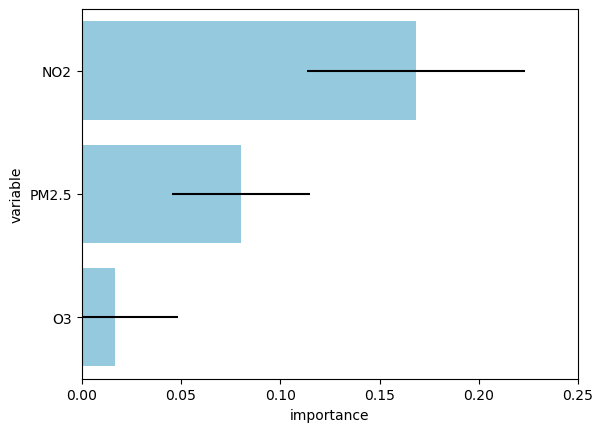

In [88]:
# Plot air quality importances as bar chart
plot= sns.barplot(data= class_imp_df, x= 'importances', y= 'variables', color= 'skyblue', xerr=class_imp_df['SD'])
plot.set_xlim(0,0.25)
plot.axvline(x = 0, color= 'black', lw= 0.5) 
plot.set_xlabel("importance")
plot.set_ylabel("variable")
plt.show()

In [14]:
# Read in buoy data
buoy_file = "C:/Users/rache/Documents/University of Southern California/2023-2024 Year 4/GEOL 599 Environmental data science/data/HW8_buoy_data.xlsx" #note on path
buoy_all = pd.read_excel(buoy_file)

In [15]:
# Select needed columns
buoy = buoy_all.loc[:,['WVHT','DPD','APD','MWD','WTMP']]
buoy = buoy.rename(columns={'WVHT':'height','DPD':'dom pd','APD':'avg pd','MWD':'dir','WTMP':'temp'})
buoy[(buoy['height']==99)|(buoy['dom pd']==99)|(buoy['avg pd']==99)|(buoy['dir']==99)|(buoy['temp']==99)] #See rows with no data
buoy= buoy.drop(buoy[buoy['height']==99].index)

In [16]:
# Convert buoy data to numpy
X2 = buoy.loc[:,['dom pd','avg pd','dir','temp']].to_numpy()
y2 = buoy.loc[:,'height'].to_numpy()

In [17]:
# Split buoy data into training, validation, and test (75:10:15)
Xtr, X3 , ytr, y3 = tts(X2, y2, test_size= 0.25)
Xva, Xte, yva, yte = tts(X3, y3, test_size= 0.6)

In [18]:
# Fit linear, decision tree, random forest, and boosted regression tree models to training data
lin = linear_model.LinearRegression()
lin.fit(Xtr, ytr)
tree= DecisionTreeRegressor(max_depth= 10)
tree.fit(Xtr,ytr)
forest= RandomForestRegressor(n_estimators= 25, max_depth= 30)
forest.fit(Xtr,ytr)
bst = XGBRegressor(n_estimators=25, learning_rate=0.6,early_stopping_rounds=8)
bst.fit(Xtr, ytr, eval_set=[(Xva, yva)])
print(lin.score(Xva,yva))
print(tree.score(Xva,yva))
print(forest.score(Xva,yva))
print(bst.score(Xva,yva))

[0]	validation_0-rmse:0.38745
[1]	validation_0-rmse:0.34898
[2]	validation_0-rmse:0.34044
[3]	validation_0-rmse:0.33277
[4]	validation_0-rmse:0.32838
[5]	validation_0-rmse:0.32515
[6]	validation_0-rmse:0.32097
[7]	validation_0-rmse:0.32014
[8]	validation_0-rmse:0.31707
[9]	validation_0-rmse:0.31523
[10]	validation_0-rmse:0.31354
[11]	validation_0-rmse:0.31434
[12]	validation_0-rmse:0.31447
[13]	validation_0-rmse:0.31276
[14]	validation_0-rmse:0.31212
[15]	validation_0-rmse:0.31160
[16]	validation_0-rmse:0.30965
[17]	validation_0-rmse:0.30937
[18]	validation_0-rmse:0.30863
[19]	validation_0-rmse:0.30510
[20]	validation_0-rmse:0.30461
[21]	validation_0-rmse:0.30421
[22]	validation_0-rmse:0.30122
[23]	validation_0-rmse:0.30223
[24]	validation_0-rmse:0.30169
0.2895189126864274
0.6172515627741646
0.7129436519786948
0.6746244779968783


In [19]:
# Apply permutation feature importance to all buoy data models
result2 = permutation_importance(lin, Xva, yva, n_repeats= 10, random_state= 0)
result3 = permutation_importance(tree, Xva, yva, n_repeats= 10, random_state= 0)
result4 = permutation_importance(forest, Xva, yva, n_repeats= 10, random_state= 0)
result5 = permutation_importance(bst, Xva, yva, n_repeats= 10, random_state= 0)
print("linear: ", result2.importances_mean, result2.importances_std)
print("decision tree: ", result3.importances_mean, result3.importances_std)
print("random forest: ", result4.importances_mean, result4.importances_std)
print("boosted regression tree: ", result5.importances_mean, result5.importances_std)

linear:  [0.04872199 0.34731143 0.05159117 0.06640113] [0.00510124 0.01058457 0.00753891 0.00696479]
decision tree:  [0.34757843 0.6282082  0.59632567 0.42926768] [0.01164519 0.03154855 0.05179813 0.03714201]
random forest:  [0.46334548 0.64511625 0.611762   0.45846289] [0.02095701 0.0301683  0.03492497 0.02002139]
boosted regression tree:  [0.31159163 0.52790782 0.47449178 0.43554818] [0.01254574 0.02686443 0.0307455  0.01817363]


In [85]:
# Turn importances results into a dataframe
series2 = pd.Series(result2)
lin_imp = {'importances':series2['importances_mean'],'SD':series2['importances_std'],'variables':['dom period','avg period','direction','temperature']}
lin_imp_df = pd.DataFrame(lin_imp).sort_values(by=['importances'], ascending=False)

series3 = pd.Series(result3)
tree_imp = {'importances':series3['importances_mean'],'SD':series3['importances_std'],'variables':['dom period','avg period','direction','temperature']}
tree_imp_df = pd.DataFrame(tree_imp).sort_values(by=['importances'], ascending=False)

series4 = pd.Series(result4)
forest_imp = {'importances':series4['importances_mean'],'SD':series4['importances_std'],'variables':['dom period','avg period','direction','temperature']}
forest_imp_df = pd.DataFrame(forest_imp).sort_values(by=['importances'], ascending=False)

series5 = pd.Series(result5)
bst_imp = {'importances':series5['importances_mean'],'SD':series5['importances_std'],'variables':['dom period','avg period','direction','temperature']}
bst_imp_df = pd.DataFrame(bst_imp).sort_values(by=['importances'], ascending=False)

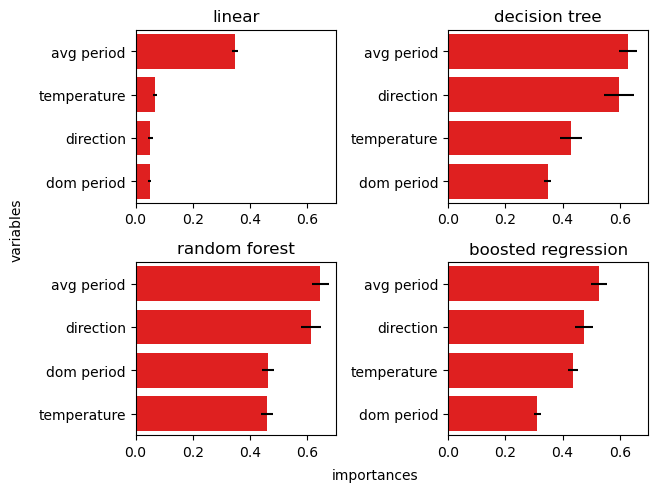

In [104]:
# Plot buoy data importances as bar charts
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
sns.barplot(ax= ax1, data= lin_imp_df, x= 'importances', y= 'variables', color= 'red', xerr=lin_imp_df['SD'])
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('linear')
sns.barplot(ax= ax2, data= tree_imp_df, x= 'importances', y= 'variables', color= 'red', xerr=tree_imp_df['SD'])
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('decision tree')
sns.barplot(ax= ax3, data= forest_imp_df, x= 'importances', y= 'variables', color= 'red', xerr=forest_imp_df['SD'])
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('random forest')
sns.barplot(ax= ax4, data= bst_imp_df, x= 'importances', y= 'variables', color= 'red', xerr=bst_imp_df['SD'])
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.set_title('boosted regression')
plt.setp((ax1,ax2,ax3,ax4), xlim= (0,0.7))
fig.tight_layout()
fig.text(0.55, -0.01, 'importances', ha='center')
fig.text(-0.01, 0.45, 'variables', ha='center', rotation='vertical')
plt.show()

In [47]:
### Feature importances for the 4 models used for predictions in buoy data almost all agree the average period was the most important, but the order of the remaining 3 variables are not as consistent. Another interesting feature is that all 4 variables are closer in importance for the three decision tree-type models, but the linear model show the average period was much more important than the other 3 variables.